# Motivation

The opening of society during an active Covid19 pandemic means reproductive rate $R_0$ is a function of time $R_0 \rightarrow R_0(t)$. In an effort to gain insight to possible reopening methods and consequences of demographic stochasticity. As such a model is needed with the ability to paramaterize the spread rate to an observable. It is common to use the confirmed cases as a metric, but historical under reporting during other epidemics makes it unceartain. Instead we will attempt to relate other data such as the number of deaths and the hospitalization data to parameterize $R_0$.

## Basic SEIR Model

Current concensus among medical research suggest that the incubation time for Covid19 has a typical range of $\tau_inc = \in [2,14]$ days(CITE). As such we will include the exposed population function. All in all, susceptable $S(t)$, exposed $E(t)$, infectious $I(t)$, removed $R(t)$ persons are going to be tracked. The following assumptions are made regarding changing populations. Any change in *susceptible* population is a result of birth/deaths or exposure to the infection. People catagorized as *exposed* either die of natural causes or enter an *infectious* period. Those that become infectious either recover or die as a result of the virus or by natural cuases. Finally, the *removed* population can only decrease from natural causes.The simplest equations for rates of change in S, E, I, R are below. 

$$\frac{dS}{dt} = \mu N - S \left( \beta \frac{I}{N} + \mu \right) $$

$$\frac{dE}{dt} = \beta \frac{S I}{N} - E(\sigma + \mu) $$

$$\frac{dI}{dt} = \sigma E - I(\gamma + \mu) $$

$$\frac{dR}{dt} = \gamma I - \mu R$$

### Function Arguements

Above the rates moving people from one category to another are taken to be constant.Eventually, we will add a driving function which varies over time. A list of the variable and thier meaning follows:

- $\mu$ = *Births/Deaths frequency* $[T^{-1}]$ *This could also be considered as*$[Pop \ T^{-1}]$ and remove the N
- $\beta$ = *Contact frequency* $[T^{-1}]$
- $\sigma$ = *Latent frequncy* $[T^{-1}]$
- $\gamma$ = *Removal frequency* $[T^{-1}]$

The only known variable is $\mu$, found using US cencus population data for average life expectancy, the rate is the inverse. The rest must be inferred from fitting reported observables.

### Basic Reproduction Number $R_0$

The basic reproduction number, $R_0$ is widely employed to describe the growth of a pandemic. Define by (Cite), $R_0$ is the average number of secondary cases arising from an average primary case in an entirely susceptible population. $R_0$ is the inverse of the relative removal rate. It helps to consider the SIR model where now exposed and infectious populations are reduced to a single infected population, $G$. If we make a ratio of the rates decreasing $G$ and those increasing, we obtain $R_0^{-1}$. 

$$ G = I + E $$

$$ \frac{dG}{dt} = \frac{dI}{dt} + \frac{dE}{dt}$$

$$ \frac{dG}{dt} = \beta \frac{S I}{N} - (\mu(E+I) + I\gamma)$$ 

Now that we have a clear distinction for increasing $G^+$ and decreasing $G^-$ terms we can find the inverse of $R_0$. Also notice that the reproductive rate includes deaths not directly resulting from the infection.

$$ R_0^{-1} = \frac{G^-}{G^+}$$

$$ R_0^{-1} = \frac{\mu(E+I) + I\gamma}{\beta \frac{S I}{N}}$$

$$ R_0^{-1} = \frac{\mu G + I\gamma}{\beta S I} N$$

$$ R_0^{-1} = N\frac{\gamma}{\beta S} + N\frac{\mu G}{\beta S I} $$

$$ R_0^{-1} = \frac{N}{S} \left( \frac{\gamma}{\beta} + \frac{\mu G}{\beta I} \right) $$

The above form for $R_0^{-1}$ is reminescent of an expansion, where if the second term is sufficiently small we can approximate the reproductive rate. The ratio of $S$ and $N$ establishes the rate per susceptible person. **This would mean that what ever (if indeed we do) ratio of population we consider spreading to N should go there, maybe (S+E+I)/N?**

$$ R_0 = \frac{\beta}{\gamma} \frac{S}{N} $$

Later, demographic effects can be modelled by introducing a contact driving function. Implimented counter spread measures can be modelled by breaking the pandemic into different time periods with varying $R_0$ values or functions of time, $R_0(t)$.

## Modelling SEIR

The set of ODE's can be easily solved using scipy's *odeint()*. The first requirement is to make a function which supplies the system of equations and an initial value array. Below note that a new compartment ($F$) is added to represent the total number of Covid19 related deaths.

Legend of Variables:

| Variable | Meaning |
|---|---|
| b | ($\beta$) Transmission Rate |
| m | ($\mu$) Typical Death/Birth Rate |
| u | Resusceptibility Rate |
| s | E $\rightarrow$ I Rate|
| g | ($\gamma$) Recovery Rate |
| d | COVID Death Rate |

In [20]:
import pylab as py
from pylab import pi
import pandas as pd
from scipy.integrate import odeint

In [21]:
N = 1.; I0 = 0.00001; E0 = 0.001; R0 = 0.0000001; F0 = 0.
S0 = N - I0 - E0
initial_c = S0, I0, E0, R0, F0

def diff_eqs(Init, t, m, b, s, g, u, d):
    S, E, I, R, F = Init # Initial conditions
    N = S + E + I + R 
    dSdt = u * R + m * N - S * (b * (I/N) + m) # Change in susceptible population
    dEdt = b * I * S / N - E * (s + m) # Change in Exposed population
    dIdt = s * E - I * (g + m + d) # change in Infected population
    dRdt = g * I - R * (m + u)
    dFdt = d * I
    # Change in removed individuals
    return dSdt, dEdt, dIdt, dRdt, dFdt

We must also create an array to pass time and list of arguements for *diff_eqs*. The arguements used here are taken from (cite cyclic paper, page 8), and $R_0=1.5$. Later, $\beta$ can be derived using our equation for $R_0$ and reported values for the infectious period, $\gamma^{-1}$.

In [31]:
dt = .1; t0 = 0; tmax = 365
time = py.arange(t0, tmax+dt, dt)

R_0 = 1.9

m = 0;  g = 1/14; s = 1/4; b = R_0 * g * N/S0; u = 1/30; d = 0.1*0.2
args = m, b, s, g, u, d

We are ready to obtain our solution for the SEIR model. The following code solves the system of equations derived for the SEIR model. Results are plotted, where the total population is scaled to 1.

In [32]:
solution = odeint(diff_eqs, initial_c, time, args=(m, b, s, g, u, d))
S, E, I, R, F = solution.T

### Plotting SEIR

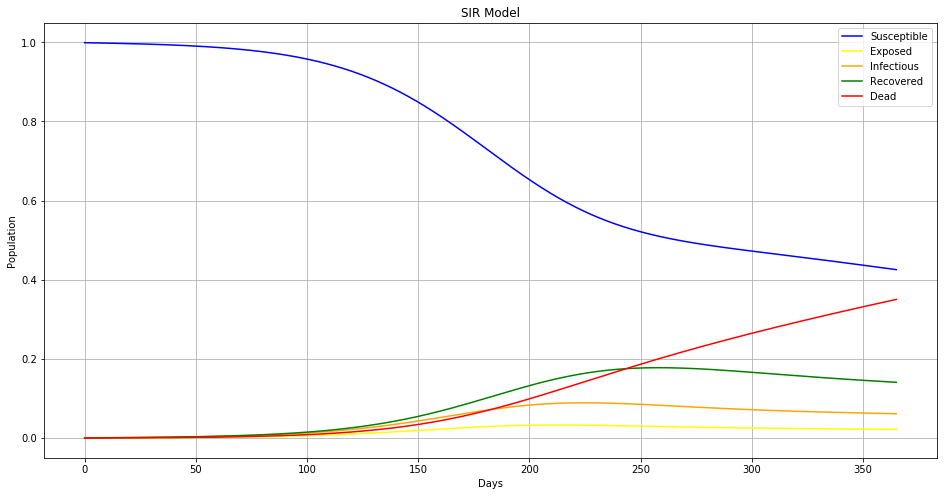

In [33]:
# Plot the results to verify model works
title = 'SIR Model'
py.close('all')
py.figure(figsize=(16,8))
py.title(title)
py.plot(time, S, color='blue', label='Susceptible', linewidth=1.5)
py.plot(time, E, color='yellow', label='Exposed', linewidth=1.5)
py.plot(time, I, color='orange', label='Infectious', linewidth=1.5)
py.plot(time, R, color='green', label='Recovered', linewidth=1.5)
py.plot(time, F, color='red', label='Dead', linewidth=1.5)
py.legend(frameon=True)
py.xlabel('Days'); py.ylabel('Population'); py.grid()
py.show()

## Consider a Time Dependent $R_0(t)$
Realistically, society has a rythem to life. If we accept that transmission ($\beta$) varies due to human behavior then there should a *term* to signify that. In a society that is not reactive, the average individual will come in contact with a larger number of people than someone in a reactive state. Here *state* here will be used to describe the current $dSdt$, $dEdt$, $dIdt$, $dRdt$ and $\beta(t)$. Approximations, or healthy claims can be made using available data and public policy about the timeliness of efforts to decrease $\beta$. Alternatively certain information regarding societal behavior may be available through study of $R_0$. Using the derivation for the transmission term $\beta$ we can possibly fit to find ..... In the derived equation below, $c$ is the probability of successful disease transmission per contact and $\kappa$ is the average number of contacts. $\kappa$ is a frequency with units, $[T^{-1}]$. 
$$ \beta = -\kappa \log(1-c)$$

In [15]:
def Beta(k, c):
    return -k * py.log(1-c)

How should we vary $\beta$ as to represent real world responses? First, the change resulting from implimentation of shutdown orders does not happend instantaneously, it happens over the course of $\tau_{sd}$. Similarly, when opening it takes $\tau_{op}$. Data is available to explore fitting for $\tau_{sd}$, but data is more limited to derive $\tau_{op}$. Additionally, time opening may never realistically reach $\tau_{op}$ but the frequency determines the $d\beta(t)/dt$. Then there are the periods when society is open but people are using safety precautions such as social distancing and wearing of masks. During these periods $\beta$ is considered constant and last for $\tau_{ss}$ for steady state. It would be helpful to be able to simulate the effect of injecting an impulse of exposed individuals. This could be a good time to apply the handy $\delta(t-a)$.

/home/steven/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: overflow encountered in exp
  import sys


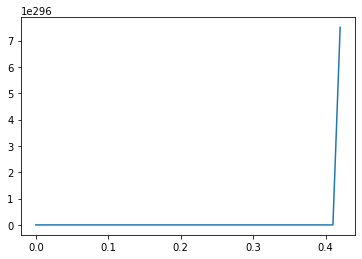

In [16]:
k_mean = 20; dk = 10; Tk = 7  # kappa parameters for oscillation about a mean
c_mean = 0.3; dc =.29; Tc = 36  # likewise for c
args = k_mean, dk, Tk, c_mean, dc, Tc

def Gauss(x, mean, std):
    A = 1/(std * py.sqrt(2*pi))
    B = py.exp((x-mean)**2 / (2*std**2))
    return A * B

x = py.arange(0,10,.01)
al = py.zeros(len(x))

for i in range(len(x)):
    al[i] = Gauss(i, 5, 1)
py.plot(x, al)

def Beta(t, args):
    k_mean, dk, Tk, c_mean, dc, Tc = args
    k = dk * py.sin(2*pi / Tk * t) + k_mean
    c =  dc * py.sin(2*pi / Tc * t) + c_mean
    return - k * py.log(1-c)

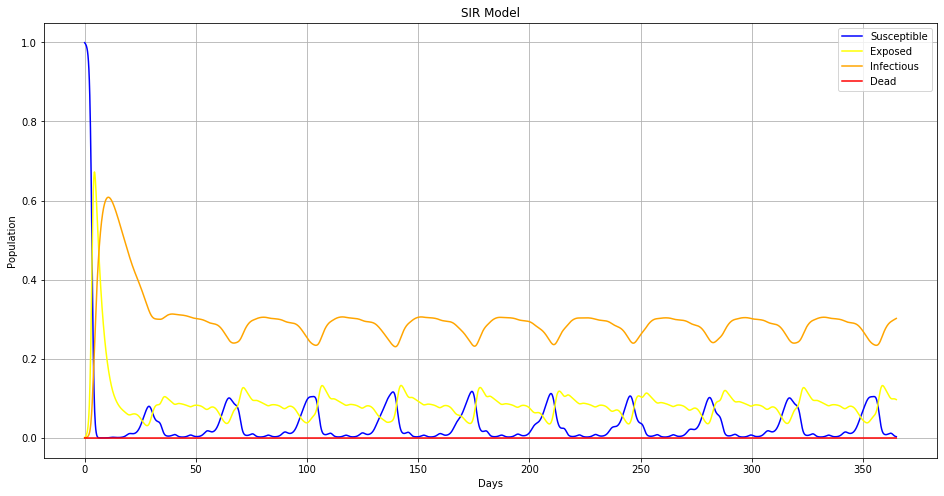

0.00010744065612938864


In [17]:
def diff_eqs(Init, t, m, b, s, g, u, d):
    S, E, I, R, F = Init # Initial conditions
    N = S + E + I + R
    b = Beta(t, args)
    dSdt = u * R + m * N - S * (b * (I/N) + m) # Change in susceptible population
    dEdt = b * I * S / N - E * (s + m) # Change in Exposed population
    dIdt = s * E - I * (g + m + d) # change in Infected population
    dRdt = g * I - R * (m + u)
    dFdt = d * I
    # Change in removed individuals
    return dSdt, dEdt, dIdt, dRdt, dFdt

solution = odeint(diff_eqs, initial_c, time, args=(m, b, s, g, u, d))
S, E, I, R, F = solution.T

# Plot the results to verify model works
title = 'SIR Model'
py.close('all')
py.figure(figsize=(16,8))
py.title(title)
py.plot(time, S, color='blue', label='Susceptible', linewidth=1.5)
py.plot(time, E, color='yellow', label='Exposed', linewidth=1.5)
py.plot(time, I, color='orange', label='Infectious', linewidth=1.5)
#py.plot(time, R, color='green', label='Recovered', linewidth=1.5)
py.plot(time, F, color='red', label='Dead', linewidth=1.5)
py.legend(frameon=True)
py.xlabel('Days'); py.ylabel('Population'); py.grid()
py.show()

print(max(F))

### Testing in SEIR Model

Now we should apply the random methods developed above to the SEIR model. To do so all that is necessary is to add a line defining $\beta$ each time step. The input parameters for contacts and probability are the same as those above. Refer to those values for making changes here.

## Compartmentalize Populations by Age Groups

COVID19 has a range of symptoms ranging from asymoptomatic to death. (First varify with our own data). There is data available regarding the age of affected individuals which can be used to assign more precise frequencies to different behaviors. It is also clear (verify) that certain age groups, the eldest, are most seriously affected. Even if the final model does not include compartmentalizing by age, this feature is easy to incorporate as only initial conditions and function parameters differ.  

In [18]:
age_range = py.array(([0,20],[20,45],[45,70],[70,100]))


In [19]:
# Define the periods for shut-down, opening, and steady state
t_b = 2 + 5 + 14  # t_sd, t_op, t_ss  *days
time = py.arange(0, t_b+1, 1)  # dt=1

In [53]:
def smoothChange(i, f, T):  # First quarter of sine wave
    A = (f - i) / 2
    B = i    
    return A * py.sin((2*py.pi) * (1/T) * 1/4) + B